<a href="https://colab.research.google.com/github/JuanManC/SaturdayAIProject/blob/master/Paneles_solares_para_autoconsumo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICCIÓN PANELES SOLARES PARA AUTOCONSUMO

## Importar liberías

In [0]:
from fastai.imports import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [0]:
# Librerias para KDtree
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial


plt.style.use('seaborn-poster')

In [0]:
from fbprophet import Prophet


In [0]:
!mkdir data

In [0]:
PATH = "/content/data/"


## DATOS

Obtenemos datos desde github

In [0]:
!wget -P {PATH} https://github.com/JuanManC/SaturdayAIProject/blob/master/data/Data.tar.gz?raw=true
  
!tar Cxvf {PATH} {PATH}Data.tar.gz?raw=true

In [0]:
df_raw = pd.read_csv(f'{PATH}DataRadiation.csv', low_memory=False) 

## **Modelo para coordenadas**

In [0]:
coordinates = df_raw

In [0]:
# Me quedo solo con la columna de coordenadas

coordinates = coordinates[['LAT', 'LON']]

In [14]:
# Elimino valores dupicados

coordinates = coordinates.drop_duplicates()
len(coordinates)

492

In [0]:
# KDTree para obtener el punto más cercano
location = [38.369265, -0.496467]
tree = spatial.cKDTree(coordinates)
dist, ix = tree.query(location, 1)

### Comenzar a tratar los datos

In [0]:
#Obtener tipos de datos del dataset
df_raw.dtypes

In [0]:
df = df_raw
# Elimino las columnas innecesarias

df = df[['LAT', 'LON', 'YEAR', 'MO', 'DY', 'ALLSKY_SFC_SW_DWN']]

In [0]:
LAT = df['LAT']==coordinates.iloc[ix,0]
LON = df['LON']==coordinates.iloc[ix,1]

In [0]:
datos = df[LAT]
datos = datos[LON]


In [0]:
datos = datos.drop(columns = ['LAT', 'LON'])

In [0]:
datos["ds"] = datos['YEAR'].map(str) + '-' + datos['MO'].map(str) + '-' + datos['DY'].map(str)

In [0]:
datos["ds"] = pd.to_datetime(datos.ds)

In [0]:
datos = datos[['ds', 'ALLSKY_SFC_SW_DWN']]
datos.columns = ['ds', 'y']

In [0]:
# elimino las filas sin datos
datos = datos[datos.y >= 0]


In [31]:
datos['y'].describe()

count    6995.000000
mean        4.625959
std         2.116291
min         0.070000
25%         2.780000
50%         4.490000
75%         6.530000
max         8.770000
Name: y, dtype: float64

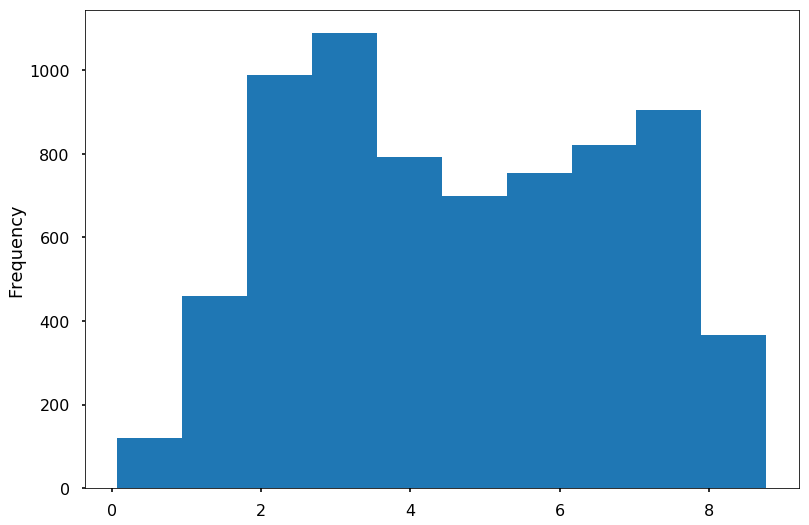

In [30]:
datos['y'].plot(kind='hist')
plt.show()

## PROPHET ##


In [0]:
import altair as alt
from vega_datasets import data

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted
  
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)


In [0]:
# Prediccion

fecha = '2011-01-01'

df_prediccion = datos.loc[datos.ds > fecha].copy()

# radiacion maxima

radiacion_maxima = df_prediccion['y'].max()

radiacion_minima = df_prediccion['y'].min()

df_prediccion['cap'] = radiacion_maxima
df_prediccion['floor'] = radiacion_minima


modelo_futuro = Prophet(growth= 'logistic', seasonality_mode = 'additive', changepoint_prior_scale =0.05, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
           ).add_seasonality(name='daily',period=1,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='weekly',period=7,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='monthly',period=30.50,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='quaterly',period=365.25/4,fourier_order=3, prior_scale = 0.1
           ).add_seasonality(name='yearly',period=365.25,fourier_order=4, prior_scale = 0.2)

modelo_futuro.fit(df_prediccion)


forecast = modelo_futuro.predict(df_prediccion)

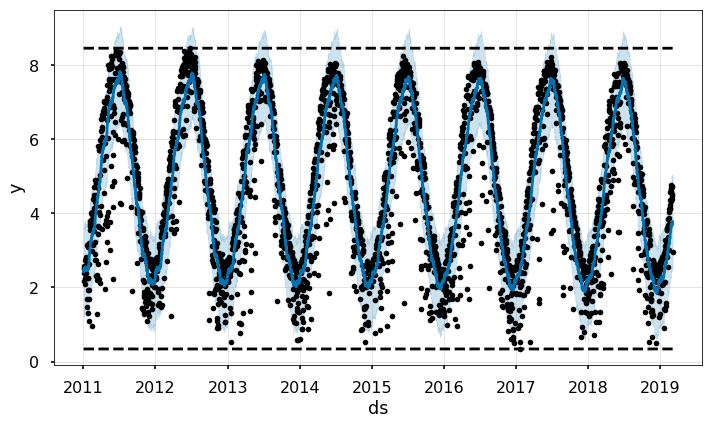

In [35]:
fig = modelo_futuro.plot(forecast)

In [39]:
# Comprobar el modelo
forecast['fact'] = df_prediccion['y'].reset_index(drop = True)


print(r2_score(forecast.fact, forecast.yhat))

0.8039527935074047


In [86]:
# Detectar anomalías 

pred = detect_anomalies(forecast)
print(len(pred))
print(r2_score(pred.fact, pred.yhat))

2977
0.8039527935074047


In [87]:
 plot_anomalies(pred)

LayerChart({
  config: Config({
    title: TitleConfig({
      fontSize: 20
    })
  }),
  height: 450,
  layer: [Chart({
    data:              ds     trend      yhat  ...  fact  anomaly  importance
    0    2011-01-02  4.461128  2.435083  ...  2.39        0    0.000000
    1    2011-01-03  4.461122  2.481369  ...  2.53        0    0.000000
    2    2011-01-04  4.461115  2.443038  ...  2.58        0    0.000000
    3    2011-01-05  4.461109  2.521895  ...  2.17        0    0.000000
    4    2011-01-06  4.461102  2.503780  ...  2.51        0    0.000000
    5    2011-01-07  4.461096  2.509591  ...  2.10        0    0.000000
    6    2011-01-08  4.461090  2.470992  ...  2.73        0    0.000000
    7    2011-01-09  4.461083  2.545467  ...  2.25        0    0.000000
    8    2011-01-10  4.461077  2.557092  ...  2.47        0    0.000000
    9    2011-01-11  4.461070  2.489255  ...  2.52        0    0.000000
    10   2011-01-12  4.461064  2.543233  ...  2.76        0    0.000000
    11   2011-01-13  4.461058  2.504829  ...  2.76        0    0.000000
    12   2011-01-14  4.461051  2.495747  ...  2.81        0    0.000000
    13   2011-01-15  4.461045  2.448940  ...  2.71        0    0.000000
    14   2011-01-16  4.461038  2.522822  ...  2.40        0    0.000000
    15   2011-01-17  4.461032  2.541111  ...  2.54        0    0.000000
    16   2011-01-18  4.461026  2.485036  ...  1.70        0    0.000000
    17   2011-01-19  4.461019  2.552157  ...  1.46        0    0.000000
    18   2011-01-20  4.461013  2.524018  ...  2.62        0    0.000000
    19   2011-01-21  4.461006  2.519040  ...  3.16        0    0.000000
    20   2011-01-22  4.461000  2.469328  ...  3.10        0    0.000000
    21   2011-01-23  4.460994  2.535714  ...  1.92        0    0.000000
    22   2011-01-24  4.460987  2.547390  ...  2.25        0    0.000000
    23   2011-01-25  4.460981  2.492808  ...  1.31        0    0.000000
    24   2011-01-26  4.460974  2.576423  ...  2.25        0    0.000000
    25   2011-01-27  4.460968  2.584137  ...  1.09       -1    0.209434
    26   2011-01-28  4.460962  2.634542  ...  1.68        0    0.000000
    27   2011-01-29  4.460955  2.655220  ...  2.64        0    0.000000
    28   2011-01-30  4.460949  2.798612  ...  3.21        0    0.000000
    29   2011-01-31  4.460942  2.883594  ...  1.92        0    0.000000
    ...         ...       ...       ...  ...   ...      ...         ...
    2947 2019-02-04  4.289806  2.835416  ...  3.58        0    0.000000
    2948 2019-02-05  4.289740  2.819934  ...  3.56        0    0.000000
    2949 2019-02-06  4.289674  2.927635  ...  3.60        0    0.000000
    2950 2019-02-07  4.289608  2.939189  ...  3.58        0    0.000000
    2951 2019-02-08  4.289542  2.972507  ...  3.70        0    0.000000
    2952 2019-02-09  4.289477  2.959006  ...  3.85        0    0.000000
    2953 2019-02-10  4.289411  3.058116  ...  2.56        0    0.000000
    2954 2019-02-11  4.289345  3.096709  ...  3.37        0    0.000000
    2955 2019-02-12  4.289279  3.060300  ...  3.87        0    0.000000
    2956 2019-02-13  4.289214  3.150568  ...  4.03        0    0.000000
    2957 2019-02-14  4.289148  3.151801  ...  3.70        0    0.000000
    2958 2019-02-15  4.289082  3.183014  ...  3.72        0    0.000000
    2959 2019-02-16  4.289016  3.174626  ...  4.13        0    0.000000
    2960 2019-02-17  4.288950  3.283992  ...  3.01        0    0.000000
    2961 2019-02-18  4.288885  3.335954  ...  4.11        0    0.000000
    2962 2019-02-19  4.288819  3.314782  ...  4.14        0    0.000000
    2963 2019-02-20  4.288753  3.421751  ...  4.24        0    0.000000
    2964 2019-02-21  4.288687  3.441017  ...  4.35        0    0.000000
    2965 2019-02-22  4.288621  3.490844  ...  4.58        0    0.000000
    2966 2019-02-23  4.288556  3.499556  ...  4.60        0    0.000000
    2967 2019-02-24  4.288490  3.620949  ...  4.34        0    0.000000
    2968 2019-02-25  4.288424  3.675514  ...  4.66      

In [89]:
# Quitar anomalías
pred = pred[pred.anomaly==0]

print(r2_score(pred.fact, pred.yhat))

0.9177967604079531


In [90]:
plot_anomalies(pred)

LayerChart({
  config: Config({
    title: TitleConfig({
      fontSize: 20
    })
  }),
  height: 450,
  layer: [Chart({
    data:              ds     trend      yhat  ...  fact  anomaly  importance
    0    2011-01-02  4.461128  2.435083  ...  2.39        0         0.0
    1    2011-01-03  4.461122  2.481369  ...  2.53        0         0.0
    2    2011-01-04  4.461115  2.443038  ...  2.58        0         0.0
    3    2011-01-05  4.461109  2.521895  ...  2.17        0         0.0
    4    2011-01-06  4.461102  2.503780  ...  2.51        0         0.0
    5    2011-01-07  4.461096  2.509591  ...  2.10        0         0.0
    6    2011-01-08  4.461090  2.470992  ...  2.73        0         0.0
    7    2011-01-09  4.461083  2.545467  ...  2.25        0         0.0
    8    2011-01-10  4.461077  2.557092  ...  2.47        0         0.0
    9    2011-01-11  4.461070  2.489255  ...  2.52        0         0.0
    10   2011-01-12  4.461064  2.543233  ...  2.76        0         0.0
    11   2011-01-13  4.461058  2.504829  ...  2.76        0         0.0
    12   2011-01-14  4.461051  2.495747  ...  2.81        0         0.0
    13   2011-01-15  4.461045  2.448940  ...  2.71        0         0.0
    14   2011-01-16  4.461038  2.522822  ...  2.40        0         0.0
    15   2011-01-17  4.461032  2.541111  ...  2.54        0         0.0
    16   2011-01-18  4.461026  2.485036  ...  1.70        0         0.0
    17   2011-01-19  4.461019  2.552157  ...  1.46        0         0.0
    18   2011-01-20  4.461013  2.524018  ...  2.62        0         0.0
    19   2011-01-21  4.461006  2.519040  ...  3.16        0         0.0
    20   2011-01-22  4.461000  2.469328  ...  3.10        0         0.0
    21   2011-01-23  4.460994  2.535714  ...  1.92        0         0.0
    22   2011-01-24  4.460987  2.547390  ...  2.25        0         0.0
    23   2011-01-25  4.460981  2.492808  ...  1.31        0         0.0
    24   2011-01-26  4.460974  2.576423  ...  2.25        0         0.0
    26   2011-01-28  4.460962  2.634542  ...  1.68        0         0.0
    27   2011-01-29  4.460955  2.655220  ...  2.64        0         0.0
    28   2011-01-30  4.460949  2.798612  ...  3.21        0         0.0
    29   2011-01-31  4.460942  2.883594  ...  1.92        0         0.0
    30   2011-02-01  4.460936  2.888859  ...  3.19        0         0.0
    ...         ...       ...       ...  ...   ...      ...         ...
    2947 2019-02-04  4.289806  2.835416  ...  3.58        0         0.0
    2948 2019-02-05  4.289740  2.819934  ...  3.56        0         0.0
    2949 2019-02-06  4.289674  2.927635  ...  3.60        0         0.0
    2950 2019-02-07  4.289608  2.939189  ...  3.58        0         0.0
    2951 2019-02-08  4.289542  2.972507  ...  3.70        0         0.0
    2952 2019-02-09  4.289477  2.959006  ...  3.85        0         0.0
    2953 2019-02-10  4.289411  3.058116  ...  2.56        0         0.0
    2954 2019-02-11  4.289345  3.096709  ...  3.37        0         0.0
    2955 2019-02-12  4.289279  3.060300  ...  3.87        0         0.0
    2956 2019-02-13  4.289214  3.150568  ...  4.03        0         0.0
    2957 2019-02-14  4.289148  3.151801  ...  3.70        0         0.0
    2958 2019-02-15  4.289082  3.183014  ...  3.72        0         0.0
    2959 2019-02-16  4.289016  3.174626  ...  4.13        0         0.0
    2960 2019-02-17  4.288950  3.283992  ...  3.01        0         0.0
    2961 2019-02-18  4.288885  3.335954  ...  4.11        0         0.0
    2962 2019-02-19  4.288819  3.314782  ...  4.14        0         0.0
    2963 2019-02-20  4.288753  3.421751  ...  4.24        0         0.0
    2964 2019-02-21  4.288687  3.441017  ...  4.35        0         0.0
    2965 2019-02-22  4.288621  3.490844  ...  4.58        0         0.0
    2966 2019-02-23  4.288556  3.499556  ...  4.60        0         0.0
    2967 2019-02-24  4.288490  3.620949  ...  4.34        0         0.0
    2968 2019-02-25  4.288424  3.675514  ...  4.66      

In [0]:
# Con las anomalías eliminas me quedo con las columnas ds (fecha) y fact (valor real) 

df_limpio = pred[['ds', 'fact']]

df_limpio.columns = ['ds', 'y']

In [0]:
# Voler a generar el modelo

df_prediccion = df_limpio.copy()

# radiacion maxima

#radiacion_maxima = df_prediccion['y'].max()

#radiacion_minima = df_prediccion['y'].min()

df_prediccion['cap'] = radiacion_maxima
df_prediccion['floor'] = radiacion_minima


modelo_futuro = Prophet(growth= 'logistic', seasonality_mode = 'additive', changepoint_prior_scale =0.05, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
           ).add_seasonality(name='daily',period=1,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='weekly',period=7,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='monthly',period=30.50,fourier_order=3, prior_scale = 0.2
           ).add_seasonality(name='quaterly',period=365.25/4,fourier_order=3, prior_scale = 0.1
           ).add_seasonality(name='yearly',period=365.25,fourier_order=4, prior_scale = 0.2)

modelo_futuro.fit(df_prediccion)


forecast = modelo_futuro.predict(df_prediccion)

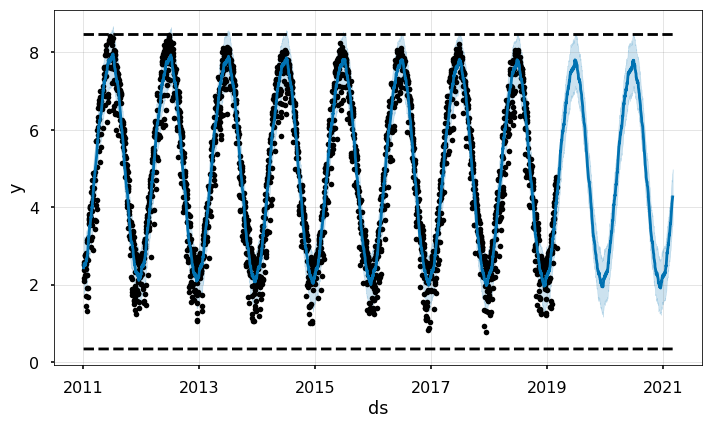

In [103]:

futuro = modelo_futuro.make_future_dataframe(periods=730, freq = 'd')
futuro['cap'] = radiacion_maxima
futuro['floor'] = radiacion_minima
forecast_futuro = modelo_futuro.predict(futuro)

fig = modelo_futuro.plot(forecast_futuro)

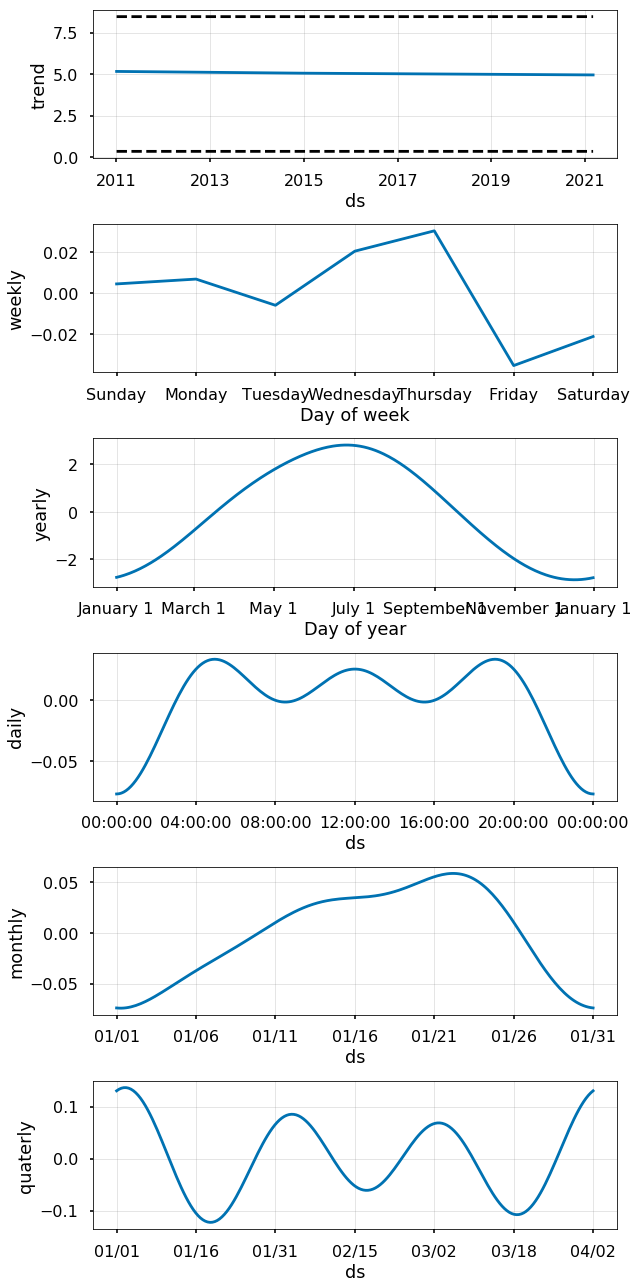

In [104]:
fig = modelo_futuro.plot_components(forecast_futuro)

In [0]:

_2020 = forecast_futuro[forecast_futuro.ds >= pd.to_datetime('01-01-2020')]

_2020 = _2020[['ds', 'yhat']]

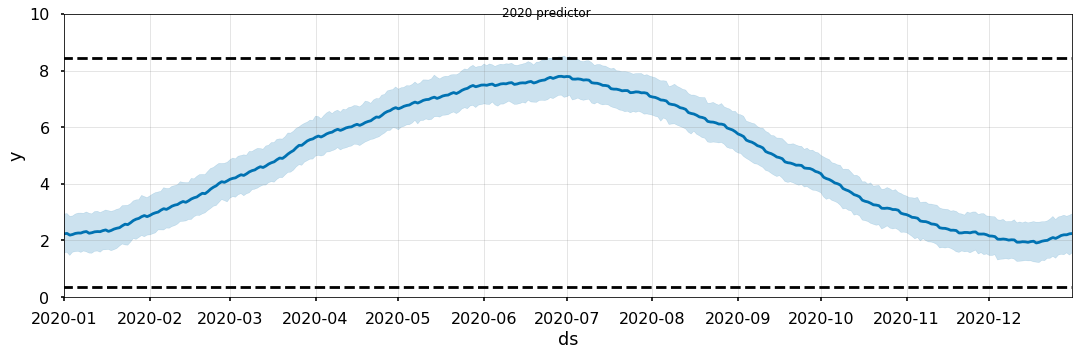

In [107]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
#ax.scatter(pd.to_datetime(datos_test.index), datos_test['y'], color='r')
fig = modelo_futuro.plot(forecast_futuro, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2020'), upper=pd.to_datetime('12-31-2020'))
ax.set_ylim(0, 10)
plot = plt.suptitle('2020 predictor')

In [108]:
# Media de radiación solar para 2020
_2020.mean()

yhat    4.600167
dtype: float64

In [109]:
_2018 = forecast_futuro[forecast_futuro.ds >= pd.to_datetime('01-01-2018')]

_2018 = forecast_futuro[forecast_futuro.ds <= pd.to_datetime('12-31-2018')]

_2018 = _2018[['ds', 'yhat']]

# Media Radiación de 2018 de prophet

_2018.mean()



yhat    4.926575
dtype: float64

In [111]:
media_anual = df_limpio[df_limpio.ds >= pd.to_datetime('01-01-2018')]

media_anual = df_limpio[df_limpio.ds <= pd.to_datetime('12-31-2018')]

# Media Radiación de 2018 con los datos

media_anual.mean()

y        4.921226
cap      8.460000
floor    0.340000
dtype: float64

# CALCULO HSP #

Valor de corrección atmosférico.

Si en esta zona, la atmósfera suele estar limpia ,como en montaña se multiplicara el anterior dato por 1.05 , si por el contrario abunda la calima, contaminación etc ,se reducirá multiplicando por 0.95 ,en caso de duda, dejadlo en 1.

 En el ejemplo, está en ciudad así que será 0.95
 
 Según los datos de  PHOTOVOLTAIC GEOGRAPHICAL INFORMATION SYSTEM (PVGIS) La inclinación para España es de 35º 
 
 Según la OCU Una casa española consume al año 9.922 kilovatios-hora (kWh)
 

DATOS PANEL SOLAR VIVIEND UNIFAMILAR: Panasonic HIT N330: 

Dimensiones: 158 x 3,5 x 79,8 cm

€224.00

![texto alternativo](https://i.imgur.com/24URAX9.png)



Características Eléctricas Potencia máxima	(Pmax)	[W]	330

Tensión para máxima potencia	(Vmp)	[V]	58

Corriente para máxima potencia	(Imp)	[A]	5.70

Tensión en circuito abierto	(Voc)	[V]	69.7

Corriente en cortocircuito	(Isc)	[A]	6.07

Protección contra sobrecorriente	[A]	15

Tolerancia de potencia a la salida	[%]	+10/-0*

Voltaje máximo del sistema	[V]	1000

Características de temperatura	Temperatura	(NOCT)	[°C]	44.0

Coeficiente de tem. de Pmax	[%/°C]	-0.258

Coeficiente de tem. de Voc	[V/°C]	-0.164

Coeficiente de tem. de Isc	[mA/°C]	3.34

 
 
 
### RADIACIÓN GLOBAL DIARIA SOBRE UNA SUPERFICIE INCLINADA Y ANGULO OPTIMO

![texto alternativo](http://calculationsolar.com/blog/wp-content/uploads/2013/06/formu01.jpg)

βopt = Inclinación Optima
Gα = Radiación global diaría
Que en nuestro caso nos da los siguiente valores:

In [112]:
radiacion_global = _2020.mean()

radiacion_global = radiacion_global * 0.95
radiacion_global = radiacion_global / (1 - 4.46 * 10**(-4) * 35) - (1.19 * 10**(-4) * 35)
print (radiacion_global)

yhat    4.435294
dtype: float64


### Energía generada por un panel solar

Egenerador-fotovoltaico = Igenerador-fotovoltaico · Vgenerador-fotovoltaico · HSP · 0,9

 0,9 sería el coeficiente del rendimiento del panel (tipicamente 85-90% al descontar ya las pérdidas)


Se simulará una conexión en paralelo de los paneles.

Igenerador-fotovoltaico = Corriente máxima de cada panel · Número de ramas en paralelo

Vgenerador-fotovoltaico= Tensión máxima de cada panel · Número de paneles en serie en cada rama 

In [113]:
Igenerador_fotovoltaico = 5.7
Vgenerador_fotovoltaico = 58

Egenerador_fotovoltaico = Igenerador_fotovoltaico * Vgenerador_fotovoltaico * radiacion_global * 0.9

Egenerador_fotovoltaico = Egenerador_fotovoltaico  / 1000

print ('Un panel genera ' + str(Egenerador_fotovoltaico) + ' KWhd')

energia_anual = Egenerador_fotovoltaico * 365

print ('Al año serían ' + str(energia_anual) + ' Kw.')

## Si ponemos 4 Ramas con 5 paneles

Igenerador_fotovoltaico = 5.7 * 2
Vgenerador_fotovoltaico = 58 * 4


Egenerador_fotovoltaico = Igenerador_fotovoltaico * Vgenerador_fotovoltaico * radiacion_global * 0.9

Egenerador_fotovoltaico = Egenerador_fotovoltaico  / 1000

print ('Un panel genera ' + str(Egenerador_fotovoltaico) + ' KWhd')

energia_anual = Egenerador_fotovoltaico * 365

print ('Al año serían ' + str(energia_anual) + ' Kw.')

Un panel genera yhat    1.319677
dtype: float64 KWhd
Al año serían yhat    481.682245
dtype: float64 Kw.
Un panel genera yhat    10.557419
dtype: float64 KWhd
Al año serían yhat    3853.457963
dtype: float64 Kw.


## CONSUMO MEDIO HOGAR

![texto alternativo](https://i.imgur.com/SJ8WtVD.png)

![texto alternativo](https://i.imgur.com/ZI42H75.png)